In [1]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import copy

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4)

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
from fairness import * 
from get_data import get_adult, get_bank, get_gk_bank, get_gk_adult

In [44]:
X_train, y_train, X_test, y_test = get_adult()
Gk = get_gk_adult(X_train)
Gk_test = get_gk_adult(X_test)

(32560, 123) (16280, 123)


/home/thomas/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
X_train, y_train, X_test, y_test = get_bank()
Gk = get_gk_bank(X_train)
Gk_test = get_gk_bank(X_test)

age quantile = [31.0, 35.0, 39.0, 45.0, 52.0]
age quantile = [31.0, 35.0, 39.0, 45.0, 52.0]


In [45]:
from sklearn.linear_model import LogisticRegression

for cc in [1]: #[0.00001, .0001, .001,.01,.1,1000000,1]
    lr = LogisticRegression(penalty='l2', C=1, max_iter=100)
    lr.fit(X_train, y_train)
    print(cc, '\t', lr.score(X_test, y_test))
    
y_pred = lr.predict(X_test)

1 	 0.7977886977886978


In [6]:
# G_test = X_test['sex_Female']
# G_test = X_test['relationship'] == 'Wife'
# G_test = X_test['sex'] == 'Male'
# G_test = X_test_ohe['fnlwgt'] % 7 == 0

# G_test = X_test['age'] > 52
# fairness(y_pred, y_test, G_test, verbose=True)

--------- G ------------
Error (1-Acc.): 0.1063
[[0.8631 0.028 ]
 [0.0782 0.0306]]
% of positive preds = 0.05866076369673492
--------- ~G ------------
Error (1-Acc.): 0.2501
[[0.6731 0.0271]
 [0.223  0.0768]]
% of positive preds = 0.10387696841329773
--------- all ------------
Error (1-Acc.): 0.2022
[[0.7364 0.0274]
 [0.1748 0.0614]]
% of positive preds = 0.08882063882063881
.

fair Demo. Parity =	 -0.03016
fair Equal Opp.   =	 0.0


/home/thomas/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(-0.030159875123903893, 1.3111506011899998e-06)

In [50]:
Gk = [Gk[0]]
Gk_test = [Gk_test[0]]

# init params
K = len(Gk)
lambda_ = [0] * K
lr = LogisticRegression(penalty='l2', C=1, max_iter=100, n_jobs=-1)
lr.fit(X_train, y_train)

l_lambda = []
l_delta = []
l_w = []
l_score = []
l_score_train = []
for t in range(4):
    print(t, end=' ')
    delta = fairness_error(lr, X_train, y_train, Gk, notion='dp')  # k-vectors
    l_delta.append(delta)
    lambda_ = lambda_ - delta  # k-vectors
    l_lambda.append(lambda_)
    w = get_w(lambda_, Gk, y_train)
    l_w.append(w)
    lr = LogisticRegression(penalty='l2', C=1, max_iter=100, n_jobs=-1)
    lr.fit(X_train, y_train, sample_weight=w)
    l_score_train.append(show_score(lr.predict(X_train), y_train, Gk[0]))
    l_score.append(show_score(lr.predict(X_test), y_test, Gk_test[0]))

0 1 2 3 

In [48]:
Gk = [Gk[0]]
Gk_test = [Gk_test[0]]

# init params
K = len(Gk)
lambda_ = [0] * K
lr = LogisticRegression(penalty='l2', C=1, max_iter=100, n_jobs=-1)
lr.fit(X_train, y_train)

l_lambda = []
l_delta = []
l_w = []
l_score = []
l_score_train = []


for t in np.linspace(-3, 5, num=50):
    print(t, end='; ')
#     delta = fairness_error(lr, X_train, y_train, Gk, notion='dp')  # k-vectors
#     l_delta.append(delta)
    lambda_ = [t] #lambda_ - delta  # k-vectors
    l_lambda.append(lambda_)
    w = get_w(lambda_, Gk, y_train)
    l_w.append(w)
    lr.fit(X_train, y_train, sample_weight=w)
    l_score_train.append(show_score(lr.predict(X_train), y_train, Gk[0]))
    l_score.append(show_score(lr.predict(X_test), y_test, Gk_test[0]))

-3.0; (32560,)
-2.5789473684210527; (32560,)
-2.1578947368421053; (32560,)
-1.736842105263158; (32560,)
-1.3157894736842106; (32560,)
-0.8947368421052633; (32560,)
-0.47368421052631593; (32560,)
-0.052631578947368585; (32560,)


/home/thomas/Documents/scikit-learn/sklearn/linear_model/logistic.py:932: ConvergenceWarning: lbfgs failed to converge (status=1): b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'. Increase the number of iterations.
  n_iter_i = _check_optimize_result(solver, opt_res, max_iter)


0.36842105263157876; (32560,)
0.7894736842105261; (32560,)
1.2105263157894735; (32560,)
1.6315789473684212; (32560,)
2.052631578947368; (32560,)
2.473684210526315; (32560,)
2.894736842105263; (32560,)


/home/thomas/Documents/scikit-learn/sklearn/linear_model/logistic.py:932: ConvergenceWarning: lbfgs failed to converge (status=1): b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'. Increase the number of iterations.
  n_iter_i = _check_optimize_result(solver, opt_res, max_iter)


3.3157894736842106; (32560,)
3.7368421052631575; (32560,)
4.157894736842104; (32560,)
4.578947368421052; (32560,)
5.0; (32560,)


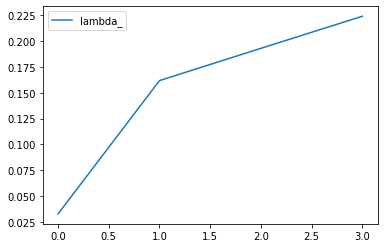

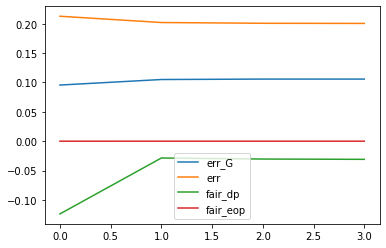

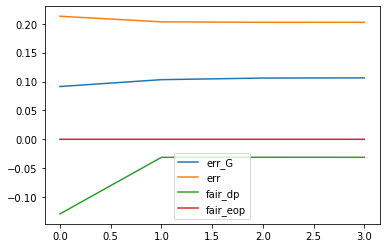

In [51]:
plt.plot(l_lambda, label='lambda_')
plt.legend()

plt.figure()
for i in range(4):
    plt.plot([x[i] for x in l_score], label = ['err_G', 'err', 'fair_dp', 'fair_eop'][i])
plt.legend()

plt.figure()
for i in range(4):
    plt.plot([x[i] for x in l_score_train], label = ['err_G', 'err', 'fair_dp', 'fair_eop'][i])
plt.legend()